In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
from casadi import *
from pdfo import *

In [2]:
n = 500
taux = 1/n
t = np.linspace(0,1,n)

In [3]:
def tracer_orientation (x,y,theta, r, i):
    if i == 1 :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' , label = "Axe local suivant x")
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' , label = "Axe local suivant y")
        plt.legend()
    else :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' )
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' )
 

In [4]:
############################################# KKT

x1i = SX.sym('x1i',1)                   
x2i = SX.sym('x2i',1)                
x3i = SX.sym('x3i',1)


x1f = SX.sym('x1f',1)
x2f = SX.sym('x2f',1)
x3f = SX.sym('x3f',1)

T = linspace (0,1,n)

In [5]:
# Je defini les vecteurs suivant :

A = SX.sym('A',6)
B = SX.sym('B',6)


u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] =u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] =u2[0:n-1]

x1=SX.sym('x1',n)
x1_prime = SX.sym('x1_prime', n+1)
x1_prime[0] = x1[0]
x1_prime[1:] =x1


x2=SX.sym('x2',n)
x2_prime = SX.sym('x1_prime', n+1)
x2_prime[0] = x2[0]
x2_prime[1:] =x2

x3=SX.sym('x3',n)
x3_prime = SX.sym('x1_prime', n+1)
x3_prime[0] = x3[0]
x3_prime[1:] =x3

Lambda = SX.sym('Lambda',n+2, 3)
Mue = SX.sym('Mue',1)

In [6]:
c1 = A[0]* (T**0) + A[1]* (T**1) + A[2]* (T**2) + A[3]* (T**3) + A[4]* (T**4) + A[5]* (T**5) 
c2 = B[0]* (T**0) + B[1]* (T**1) + B[2]* (T**2) + B[3]* (T**3) + B[4]* (T**4) + B[5]* (T**5) 

In [7]:
p1=vertcat(x1i + 10**(-4),x1_prime[2:] + 10**(-4),x1f + 10**(-4))  
g = Function('g',[x1,x1i,x1f],[p1])

In [8]:
Y1 = (x1_prime+taux*u1_prime*cos(x3_prime) - g(x1,x1i,x1f))
Y2 = (x2_prime+taux*u1_prime*sin(x3_prime) - g(x2,x2i,x2f)) 
Y3 = (x3_prime+taux*u2_prime - g(x3,x3i,x3f))
Y = SX.sym('Y',n+1 , 3)        ## notre contrainte

for i in range (n+1):
    Y[i,0]= Y1[i]
    Y[i,1]= Y2[i]
    Y[i,2]= Y3[i]       

for i in range (n+1):
    Y[i,0]= Y1[i]
    Y[i,1]= Y2[i]
    Y[i,2]= Y3[i]       
    
Y_function = Function('Y_function', [u1,u2,x1,x2,x3], [Y])


In [9]:
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y[i,:], Lambda[i,:])
    
G_lambda += (u1[0]-0.0001)*Lambda[n+1,0] + (u2[0]-0.0001)*Lambda[n+1,1] + (u1[-1]-0.0001)*Lambda[n+1,2] + (u2[-1]-0.0001)*Mue


G = Function('G', [x1,x2,x3, Lambda], [G_lambda])

## notre fonction F 
F_val = (taux/2)*(dot(c1*u1,u1)+dot(c2*u2,u2))


## le Lagrangien 
L_val = F_val + G_lambda
#print(L_val.shape)

In [10]:
L_x = SX.zeros(5, n)

for i in range (n):
    L_x[2,i]= jacobian(L_val, x1[i])
    L_x[3,i]= jacobian(L_val, x2[i])
    L_x[4,i]= jacobian(L_val, x3[i])
#print(L_x)
    
L_u = SX.zeros(5, n)
for i in range (n):
    L_u[0,i]= jacobian(L_val, u1[i])
    L_u[1,i]= jacobian(L_val, u2[i])

In [11]:
R = Function ('R', [u1,u2,x1,x2,x3, Lambda, Mue,  A, B, x1i,x2i,x3i, x1f,x2f,x3f ], [(dot(L_x,L_x) + dot(L_u,L_u))])

In [12]:
############################################# Bi-level en un coup

X1=SX.sym('X1',n)
X2=SX.sym('X2',n)  
X3=SX.sym('X3',n)  
m = SX.sym('m',1)
m = (dot(X1-x1,X1-x1) + dot(X2-x2,X2-x2) + dot(X3-x3,X3-x3))

M = Function ('M', [x1,x2,x3, X1,X2,X3], [m])

In [13]:
def BL (U1,U2,X1,X2,X3, Xi, Xf):
    opti = casadi.Opti()   

    A = opti.variable(6)
    B = opti.variable(6)
    Lambda = opti.variable(n+2,3)
    Mue = opti.variable(1)
    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)
    c1 = A[0]* (T**0) + A[1]* (T**1) + A[2]* (T**2) + A[3]* (T**3) + A[4]* (T**4) + A[5]* (T**5) 
    c2 = B[0]* (T**0) + B[1]* (T**1) + B[2]* (T**2) + B[3]* (T**3) + B[4]* (T**4) + B[5]* (T**5) 


    opti.minimize((10**5)*R(u1,u2,x1,x2,x3, Lambda, Mue, A, B , X1[0],X2[0],X3[0], X1[-1],X2[-1],X3[-1] ) + (M(x1,x2,x3, X1,X2,X3)) )  

    for j in range (n) : 
        opti.subject_to( 0 <= c1[j])
        opti.subject_to( 0 <= c2[j] )
        opti.subject_to(  c1[j] + c2[j] == 1)

    opti.subject_to( x1[0]==Xi[0] + 10**(-4))        
    opti.subject_to( x2[0]==Xi[1] + 10**(-4))
    opti.subject_to( x3[0]==Xi[2] + 10**(-4))

    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )
    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)
    
    opti.subject_to( u1[:n-1]*cos(x3[:n-1])==(x1[1:] + 10**(-4) - x1[:n-1])/taux )
    opti.subject_to( u1[:n-1]*sin(x3[:n-1])==(x2[1:] + 10**(-4) - x2[:n-1])/taux )
    opti.subject_to( u2[:n-1] ==(x3[1:] + 10**(-4) - x3[:n-1])/taux)

    opti.subject_to( x1[-1]==Xf[0] + 10**(-4))
    opti.subject_to( x2[-1]==Xf[1] + 10**(-4))
    opti.subject_to( x3[-1]==Xf[2] + 10**(-4))
    
    opti.set_initial(u1, U1)
    opti.set_initial(u2, U2)
    opti.set_initial(x1, X1)
    opti.set_initial(x2, X2)
    opti.set_initial(x3, X3)
    

    opti.solver('ipopt')      


    sol = opti.solve()
    
    return sol.value(A), sol.value(B), sol.value(x1), sol.value(x2), sol.value(x3)

In [14]:
A = [1/10,3/10,2/10,1/10,2/10,1/10]

C1 = A[0]* (t**0) + A[1]* (t**1) + A[2]* (t**2) + A[3]* (t**3) + A[4]* (t**4) + A[5]* (t**5) 
C2 = 1 - C1

In [15]:
x1i = -4                   # condition initiale de x1
x2i = -3.4                 # condition initiale de x2
x3i = pi/4              # condition initiale de x3


x1f = 0           # condition final de x1
x2f = 0            # condition final de x2
x3f = pi/2         # condition final de x3

In [16]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

u1 = opti.variable(n)
u2 = opti.variable(n)
x1 = opti.variable(n)
x2 = opti.variable(n)
x3 = opti.variable(n)

opti.minimize(   (taux/2)*(dot(C1*u1,u1)+dot(C2*u2,u2))   )    # ma fonction objetion

# mes fonctions de contrainte d'égalité:

## pour les condition initial
opti.subject_to( x1[0]==x1i + 10**(-4))        
opti.subject_to( x2[0]==x2i + 10**(-4))
opti.subject_to( x3[0]==x3i + 10**(-4))

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001)
opti.subject_to( u2[-1] == 0.0001)


## pour les contraintes d'égaliter
opti.subject_to( u1[:n-1]*cos(x3[:n-1])==(x1[1:] + 10**(-4) - x1[:n-1])/taux )
opti.subject_to( u1[:n-1]*sin(x3[:n-1])==(x2[1:] + 10**(-4) - x2[:n-1])/taux )
opti.subject_to( u2[:n-1] ==(x3[1:] + 10**(-4) - x3[:n-1])/taux)

## pour les conditions finales
opti.subject_to( x1[-1]==x1f + 10**(-4))
opti.subject_to( x2[-1]==x2f + 10**(-4))
opti.subject_to( x3[-1]==x3f + 10**(-4))

#p_opts = dict(print_time = False, verbose = False)
#s_opts = dict(print_level = 0)


opti.solver('ipopt'  ) #, p_opts,s_opts)      


sol = opti.solve()



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality co

In [17]:
U1 = sol.value(u1)
U2 = sol.value(u2)
X1 = sol.value(x1)
X2 = sol.value(x2)
X3 = sol.value(x3)

In [18]:
Xi = [x1i,x2i,x3i]
Xf = [x1f,x2f,x3f]


A_BL1,B_BL1,X1_BL1,X2_BL1,X3_BL1 = BL (U1,U2,X1,X2,X3, Xi, Xf)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    11499
Number of nonzeros in inequality constraint Jacobian.:     6000
Number of nonzeros in Lagrangian Hessian.............:    31002

Total number of variables............................:     4019
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2007
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [19]:
c1_BL1 = A_BL1[0] + A_BL1[1]*t + A_BL1[2]* (t**2) + A_BL1[3]* (t**3) + A_BL1[4]* (t**4) + A_BL1[5]* (t**5) 
c2_BL1 = B_BL1[0] + B_BL1[1]*t + B_BL1[2]* (t**2) + B_BL1[3]* (t**3) + B_BL1[4]* (t**4) + B_BL1[5]* (t**5) 

In [20]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

u1 = opti.variable(n)
u2 = opti.variable(n)
x1 = opti.variable(n)
x2 = opti.variable(n)
x3 = opti.variable(n)

opti.minimize(   (taux/2)*(dot(c1_BL1*u1,u1)+dot(c2_BL1*u2,u2))   )    # ma fonction objetion

# mes fonctions de contrainte d'égalité:

## pour les condition initial
opti.subject_to( x1[0]==x1i + 10**(-4))        
opti.subject_to( x2[0]==x2i + 10**(-4))
opti.subject_to( x3[0]==x3i + 10**(-4))

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001)
opti.subject_to( u2[-1] == 0.0001)


## pour les contraintes d'égaliter
opti.subject_to( u1[:n-1]*cos(x3[:n-1])==(x1[1:] + 10**(-4) - x1[:n-1])/taux )
opti.subject_to( u1[:n-1]*sin(x3[:n-1])==(x2[1:] + 10**(-4) - x2[:n-1])/taux )
opti.subject_to( u2[:n-1] ==(x3[1:] + 10**(-4) - x3[:n-1])/taux)

## pour les conditions finales
opti.subject_to( x1[-1]==x1f + 10**(-4))
opti.subject_to( x2[-1]==x2f + 10**(-4))
opti.subject_to( x3[-1]==x3f + 10**(-4))

#p_opts = dict(print_time = False, verbose = False)
#s_opts = dict(print_level = 0)


opti.solver('ipopt'  ) #, p_opts,s_opts)      


sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [21]:
U1_BL1 = sol.value(u1)
U2_BL1 = sol.value(u2)
X1_BL1 = sol.value(x1)
X2_BL1 = sol.value(x2)
X3_BL1 = sol.value(x3)

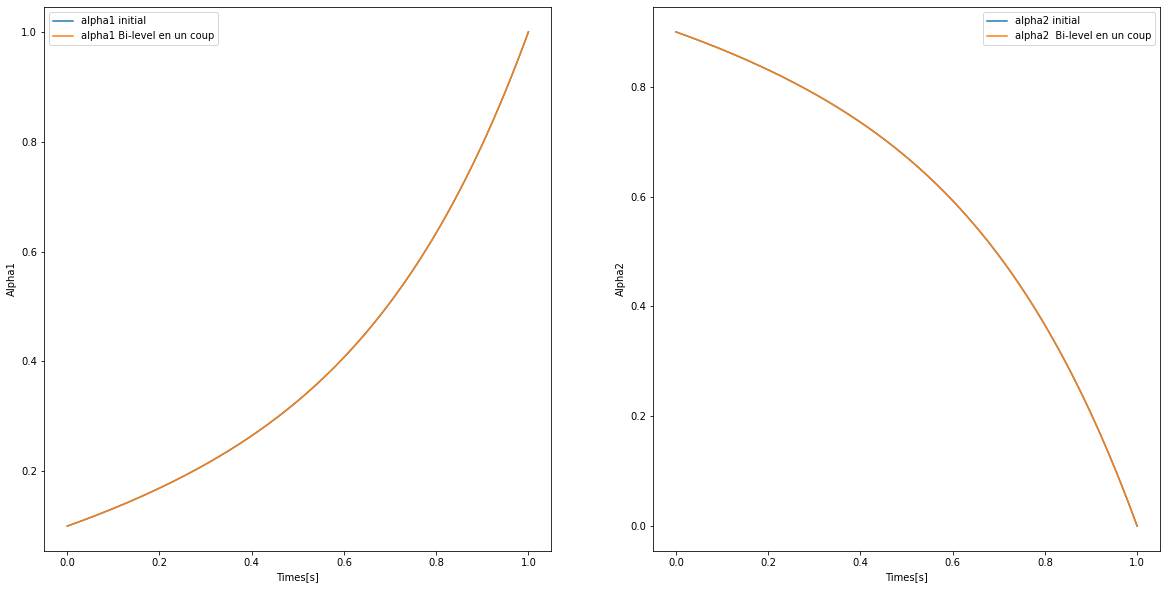

In [25]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t,C1, label = 'alpha1 initial')
plt.plot(t,c1_BL1, label = 'alpha1 Bi-level en un coup')
plt.xlabel('Times[s]')
plt.ylabel('Alpha1')
plt.legend()

plt.subplot(1,2,2)
plt.plot(t,C2, label = 'alpha2 initial')
plt.plot(t,c2_BL1, label = 'alpha2  Bi-level en un coup')
plt.xlabel('Times[s]')
plt.ylabel('Alpha2')
plt.legend()


Text(0, 0.5, 'Y[m]')

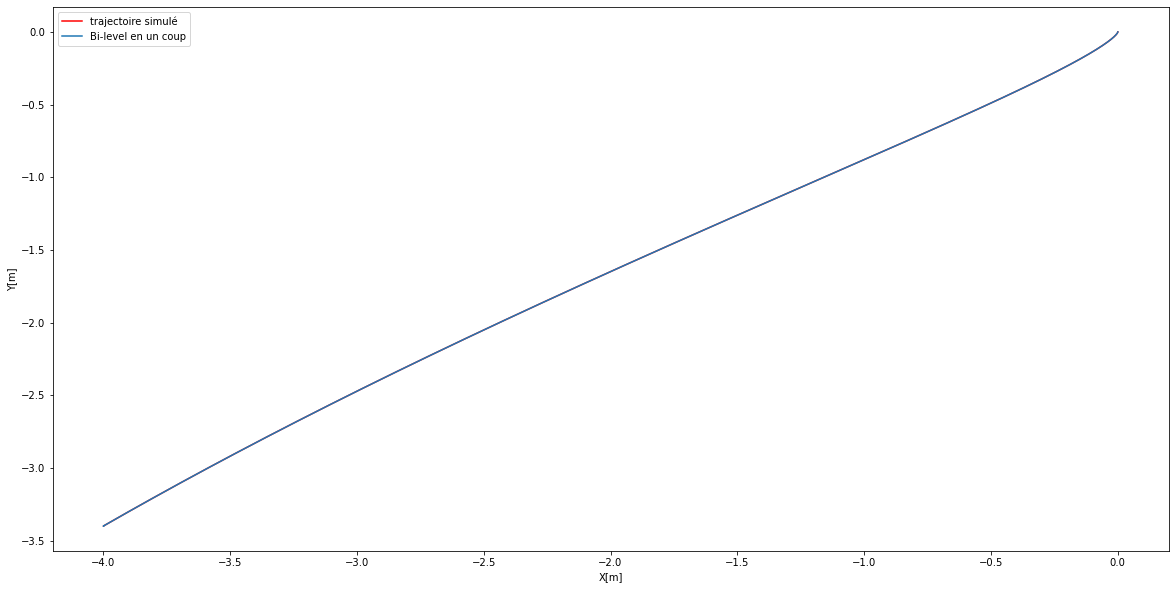

In [24]:
plt.figure(figsize = (20,10))
plt.plot(X1,X2, 'r',label = 'trajectoire simulé')
plt.plot(X1_BL1,X2_BL1, label = 'Bi-level en un coup')
plt.legend()

plt.xlabel('X[m]')
plt.ylabel('Y[m]')